<a href="https://colab.research.google.com/github/satfail/AI-Reading-Materials/blob/master/Transferencia_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/CelulasFirstTry"

#raiz
PATH = "/content/drive/My Drive"

#ipunt

INPATH = PATH + '/CelulasFirstTry'



#checkpoints

CPATH = PATH + '/checkpointsCelulas'

entrenamiento  test


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
import pathlib
data_train = pathlib.Path(INPATH + '/entrenamiento/') 
count = len(list(data_train.glob('*/*.tiff')))
print('Entrenamiento : ' + str(count))
data_test = pathlib.Path(INPATH + '/test/') 
count = len(list(data_test.glob('*/*.tiff')))
print('Test : ' + str(count))
data_train


Entrenamiento : 1268
Test : 60


PosixPath('/content/drive/My Drive/CelulasFirstTry/entrenamiento')

# Diferencias a tener en cuenta
En un momento, descargará tf.keras.applications.MobileNetV2 para usarlo como modelo base. Este modelo espera valores de píxeles en [-1,1] , pero en este punto, los valores de píxeles en sus imágenes están en [0-255] . Para cambiar su escala, utilice el método de preprocesamiento incluido con el modelo.

feature y samplewise
rescale 2./255

In [5]:
from keras.preprocessing.image import ImageDataGenerator


batch_size = 32
img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
    featurewise_center=True, samplewise_center=True, # [-1,1] para 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=[0.8,1],
    rescale=2./255,
    validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator( featurewise_center=True, 
                                  samplewise_center=True,
                                  rescale=2./255)

train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    
    shuffle=True,
    class_mode='binary',
    subset='training',
    seed=42) # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_train, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='validation',
    seed=42) # set as validation data

test_generator = test_datagen.flow_from_directory(INPATH + '/test',
                                                target_size=(224,224),
                                                shuffle=False,
                                                batch_size=1,
                                             class_mode='binary')


Found 1016 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 252 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Nueva sección

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


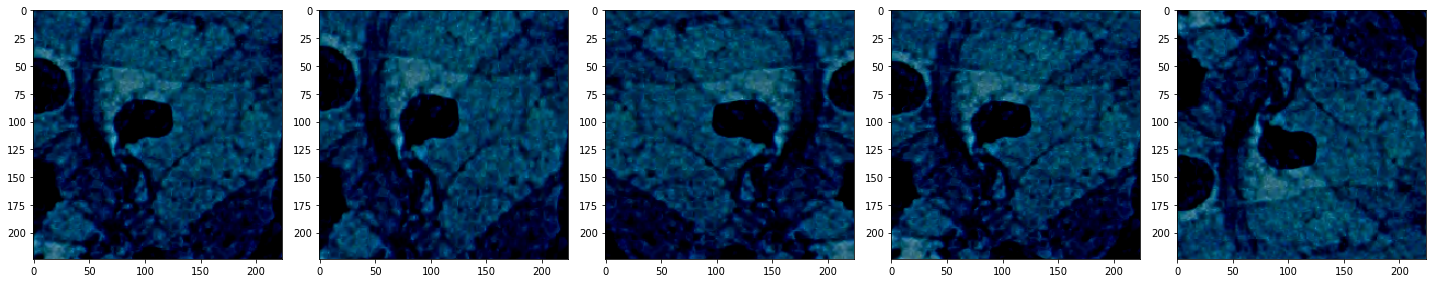

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [7]:
IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(32, 7, 7, 1280)


In [9]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_______________________________________________

In [17]:
len(model.trainable_variables)

2

In [18]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


8/8 [==============================] - 4s 356ms/step - loss: 0.8100 - accuracy: 0.3808


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.41


In [20]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
32/32 [==============================] - 17s 469ms/step - loss: 0.7572 - accuracy: 0.4951 - val_loss: 0.6845 - val_accuracy: 0.5833
Epoch 2/20
32/32 [==============================] - 14s 442ms/step - loss: 0.6658 - accuracy: 0.5945 - val_loss: 0.6776 - val_accuracy: 0.5952
Epoch 3/20
32/32 [==============================] - 14s 442ms/step - loss: 0.5832 - accuracy: 0.6703 - val_loss: 0.5987 - val_accuracy: 0.6667
Epoch 4/20
32/32 [==============================] - 14s 438ms/step - loss: 0.5043 - accuracy: 0.7421 - val_loss: 0.5497 - val_accuracy: 0.7222
Epoch 5/20
32/32 [==============================] - 14s 439ms/step - loss: 0.4489 - accuracy: 0.7953 - val_loss: 0.5492 - val_accuracy: 0.7063
Epoch 6/20
32/32 [==============================] - 14s 437ms/step - loss: 0.4144 - accuracy: 0.8071 - val_loss: 0.4888 - val_accuracy: 0.7738
Epoch 7/20
32/32 [==============================] - 14s 444ms/step - loss: 0.3759 - accuracy: 0.8543 - val_loss: 0.4740 - val_accuracy: 0.7698

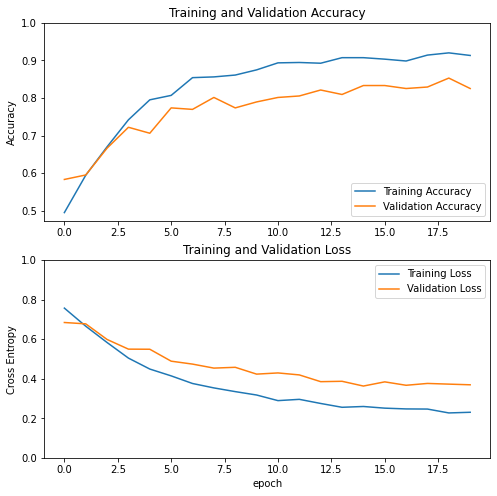

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine Tuning
En el experimento de extracción de características, solo estaba entrenando algunas capas sobre un modelo base de MobileNet V2. Los pesos de la red preentrenada no se actualizaron durante el entrenamiento.

Una forma de aumentar aún más el rendimiento es entrenar (o "ajustar") los pesos de las capas superiores del modelo previamente entrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar las ponderaciones de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

Nota: Esto solo debe intentarse después de haber entrenado el clasificador de nivel superior con el modelo entrenado previamente configurado como no entrenable. Si agrega un clasificador inicializado aleatoriamente sobre un modelo previamente entrenado e intenta entrenar todas las capas de manera conjunta, la magnitud de las actualizaciones de gradiente será demasiado grande (debido a los pesos aleatorios del clasificador) y su modelo previamente entrenado olvida lo que ha aprendido.

Además, debe intentar ajustar una pequeña cantidad de capas superiores en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que asciende, las características son cada vez más específicas del conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste es adaptar estas características especializadas para trabajar con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

In [22]:
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_____________________________________________

In [27]:
fine_tune_epochs = 20
total_epochs =  20 + fine_tune_epochs #epochs iniciales +  las de fine tuning
history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 20/40
32/32 [==============================] - 20s 508ms/step - loss: 0.2424 - accuracy: 0.8988 - val_loss: 0.4474 - val_accuracy: 0.7659
Epoch 21/40
32/32 [==============================] - 15s 481ms/step - loss: 0.1747 - accuracy: 0.9297 - val_loss: 0.3162 - val_accuracy: 0.8413
Epoch 22/40
32/32 [==============================] - 15s 484ms/step - loss: 0.1464 - accuracy: 0.9522 - val_loss: 0.3564 - val_accuracy: 0.8254
Epoch 23/40
32/32 [==============================] - 15s 481ms/step - loss: 0.1321 - accuracy: 0.9557 - val_loss: 0.3280 - val_accuracy: 0.8373
Epoch 24/40
32/32 [==============================] - 15s 478ms/step - loss: 0.1265 - accuracy: 0.9524 - val_loss: 0.3006 - val_accuracy: 0.8611
Epoch 25/40
32/32 [==============================] - 15s 474ms/step - loss: 0.1381 - accuracy: 0.9454 - val_loss: 0.3519 - val_accuracy: 0.8333
Epoch 26/40
32/32 [==============================] - 15s 469ms/step - loss: 0.0865 - accuracy: 0.9746 - val_loss: 0.3182 - val_accuracy:

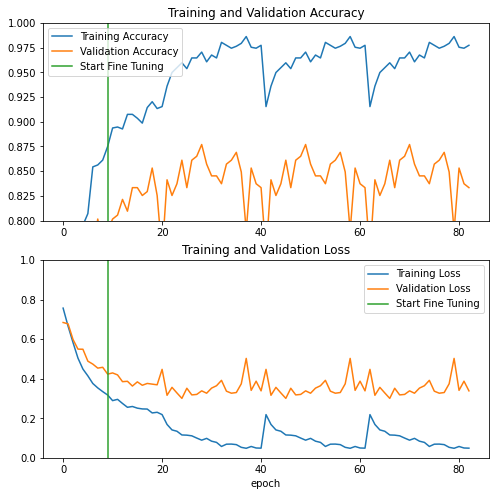

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

print(steps_per_epoch)
print(validation_steps)

model.evaluate(x=validation_generator,
steps=validation_steps)

31
7


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


7/7 [==============================] - 3s 366ms/step - loss: 0.3651 - accuracy: 0.8304


[0.365105003118515, 0.8303571343421936]

In [33]:
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


60/60 [==============================] - 26s 435ms/step


In [34]:
test_predict.shape

(60, 1)

In [35]:
test_predict

array([[-3.0811598 ],
       [ 0.77869326],
       [-4.6693916 ],
       [-4.9618645 ],
       [ 0.9761311 ],
       [ 1.6732365 ],
       [-1.6495781 ],
       [-0.35398653],
       [-0.33572733],
       [-1.8504654 ],
       [-7.898154  ],
       [-1.7310798 ],
       [-4.980143  ],
       [-7.111163  ],
       [-4.649604  ],
       [-4.9455757 ],
       [-6.4473147 ],
       [-6.3772364 ],
       [-6.4428434 ],
       [-4.672819  ],
       [-1.9702239 ],
       [-6.2417574 ],
       [-5.009642  ],
       [-0.7193989 ],
       [-7.7230268 ],
       [-3.9731898 ],
       [-5.600294  ],
       [-7.248707  ],
       [-7.0952206 ],
       [-5.9007254 ],
       [ 8.592903  ],
       [11.2105875 ],
       [14.770224  ],
       [ 6.3528643 ],
       [ 8.727792  ],
       [ 9.394339  ],
       [10.573494  ],
       [11.399477  ],
       [ 7.737343  ],
       [ 2.3493602 ],
       [ 7.2937436 ],
       [ 5.884218  ],
       [11.5848    ],
       [ 8.8651495 ],
       [ 6.2894344 ],
       [ 0

In [38]:
predict = []

for i in test_predict:
  if i > 0:
    predict.append(1)
  else:
    predict.append(0)

predict = np.asarray(predict)

In [39]:
np.asarray(predict)

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_generator.classes, np.asarray(predict))
accuracy

0.95

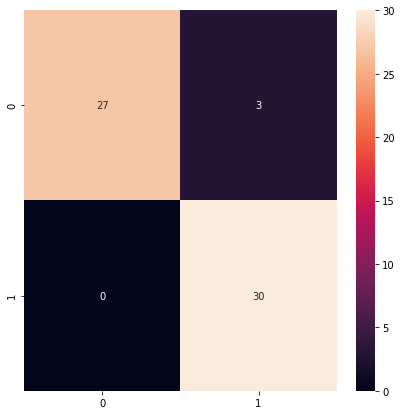

In [41]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)